In [2]:
import pandas as pd
import os

import scipy.stats
from scipy.stats import hypergeom
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
from itertools import combinations
%pylab inline
import collections
import numpy
import math
import random
from matplotlib.ticker import AutoMinorLocator

Populating the interactive namespace from numpy and matplotlib


In [3]:
#these files were generated using '101319 cofactor analysis.ipynb' and '101319  single factor analysis.ipynb'
ba_cf=pd.read_csv("../../output/072020_cofactor_analysis_ba.csv",sep=',')
sc_cf=pd.read_csv("../../output/072020_cofactor_analysis_sc.csv",sep=',')
ba_df=pd.read_csv("../../output/072020_single_factor_analysis_data_DE_NB_ba.csv",sep=',')
sc_df=pd.read_csv("../../output/072020_single_factor_analysis_data_DE_NB_sc.csv",sep=',')

In [4]:
nclist=[]
for nc in sc_df["neuron_class"].values:
    if '?' in nc:
        nclist.append('%s' %(nc[:-1]))
    else:
        nclist.append(nc)
sc_df['neuron_class']=nclist
#remove question marks so can merge datasets.

In [5]:
#compare models per TF. -how correlated are they? what is overlap of A-1 models?

#correlation of categorial cata (models by TF per neuron class)
#correltion using ranked data (rs test per TF per neuron class)

In [6]:
m=ba_df.merge(sc_df,on=['motif_ID','neuron_class', 'TF'])
m.head(2)

Unnamed: 0_x model_x     TF     motif_ID neuron_class  marker_count_x  \
0             0     A-I  cfi-1  M01667_2.00          AVD            66.0   
1             1     A-I  cfi-1  M01667_2.00           DA            78.0   

   obs_motif_x  exp_motif_x      fc_x  hg_pval_x  ...  obs_motif_y  \
0         52.0    38.160048  1.362682   0.000278  ...          201   
1         62.0    45.098238  1.374777   0.000045  ...          692   

   exp_motif_y      fc_y     hg_pval_y     rs_pval_y  best_subset_rs_pval_y  \
0   148.014731  1.357973  1.820000e-12  1.590000e-21           1.500000e-43   
1   520.942470  1.328362  2.060000e-34  2.230000e-56          4.050000e-130   

   num_genes_in_subset_y    hg_pval*_y    rs_pval*_y  best_subset_rs_pval*_y  
0                    123  7.420000e-12  1.940000e-20            7.620000e-43  
1                    414  1.040000e-32  1.380000e-53           4.190000e-128  

[2 rows x 29 columns]

In [7]:
#compare top two predicted regaultors per neuron class between sc and ba data?
m[['model_x','model_y','motif_ID','neuron_class']].head(2)


model_x model_y     motif_ID neuron_class
0     A-I     A-I  M01667_2.00          AVD
1     A-I     A-I  M01667_2.00           DA

In [8]:
limit=2
def match(x,y,limit):
    if limit==1:
        if x==y:
            return 1
        else:
            return 0
    if limit==2:
        if set(x)==set(y):
            return 1
        
        if len(set(x)-set(y))==1:
            return .5
        else:
            return 0
        
        
    
d=pd.DataFrame()
headers=['nc','ba','sc','prop']
m=m.sort_values(ascending=True,by=['rs_pval*_x','neuron_class'])
for nc in m['neuron_class'].drop_duplicates().values[:]:
    
    r=m.loc[(m['neuron_class']==nc) & (m["model_x"]=='A-I') & (m["model_y"]=='A-I')]
   
    r_x=r['TF'].head(limit).values
    
    r=r.sort_values(ascending=True,by=['rs_pval*_y','neuron_class'])
    r_y=r['TF'].head(limit).values
    
    if len(r_x)>0:
        if len(r_x)>1:
            r_xs='%s, %s' %(r_x[0],r_x[1])
        if len(r_x)==1:
            r_xs='%s' %(r_x[0])
        if len(r_y)>1:
            r_ys='%s, %s' %(r_y[0],r_y[1])
        if len(r_y)==1:
            r_ys='%s' %(r_y[0])
            
        
        result=[nc, r_xs, r_ys, match(r_x,r_y,limit)]
        
            
        dictionary = dict(zip(headers, result))
        d=d.append(dictionary,ignore_index=True)
d=d[headers]

113
0.3805309734513274
104 0.9203539823008849 --prop agreement in top 2 predicted A-1 regulators per neuron class (of 96 neuron classes with a predicted A-1 regulator, 83% show agreement in top 2 between datasets)



nc                    ba                    sc  prop
0  AIY  ceh-10--ttx-3, fax-1  ceh-10--ttx-3, fax-1   1.0
1  ASE         che-1, ztf-11         che-1, ztf-11   1.0
2  HSN         egl-5, ztf-11        unc-86, ztf-11   0.5
3  ADL         hlh-4, unc-86         hlh-4, ztf-11   0.5
4  PLM        ztf-11, unc-86         ztf-11, hsf-1   0.5
5  ALM         ztf-11, pag-3         hsf-1, unc-86   0.0
6  AFD         ztf-11, dmd-8         dmd-8, ztf-11   1.0
7  PVC        ztf-11, ceh-18         ztf-11, cfi-1   0.5
8  AWC         ztf-11, gei-3         ztf-11, gei-3   1.0
9  AVA         ztf-11, tbx-2         ztf-11, fax-1   0.5

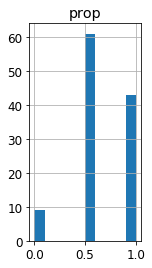

In [9]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('legend', fontsize=12)    # legend fontsize

colorlist=['deepskyblue','lightblue','green','yellowgreen','lightgrey','darkslategrey']

rcParams['figure.figsize'] = 2, 4

print(len(d))
p1=len(d.loc[d['prop']==1])
p_2=len(d.loc[d['prop']>0])
print(p1/len(d))
print(p_2, p_2/len(d), '--prop agreement in top 2 predicted A-1 regulators per neuron class (of 96 neuron classes with a predicted A-1 regulator, 83% show agreement in top 2 between datasets)')
print()
d.hist()
plt.savefig('../../output/figure_parts/Fig11_props_top2.pdf')

d.to_csv("../../output/figure_parts/props.csv")
d.head(10)

In [10]:
#add sc neuron name so can see which ones were quetionable identifications
sc_df=pd.read_csv("../../output/012120_single_factor_analysis_data_DE_NB_sc.csv",sep=',')
sc_nclasses=list(sc_df["neuron_class"].drop_duplicates().values)
mlist=[]
for nc in d['nc'].values:
    if '%s?' %nc in sc_nclasses:
        mlist.append('%s?' %nc)
    else:
        mlist.append(nc)
d['sc_nc_name']=mlist
d.to_csv('../../MS/Supp_Tables_Jan_2020/Supplementary_Table_3C_top_2_regulators_per_data_source.csv',sep=',')

In [11]:
d.loc[d['prop']==0]

nc              ba              sc  prop sc_nc_name
5    ALM   ztf-11, pag-3   hsf-1, unc-86   0.0        ALM
34   AVB  ceh-18, unc-42    unc-3, fax-1   0.0        AVB
45    VB  ceh-18, unc-62  cebp-1, ceh-48   0.0         VB
58   PHC  unc-86, ceh-14    nob-1, php-3   0.0        PHC
65   AWA   ztf-11, egl-5  nhr-216, odr-7   0.0        AWA
74   DVC  ceh-58, ztf-14    php-3, nhr-6   0.0        DVC
76   RIF  ceh-16, ceh-18   unc-3, ztf-11   0.0        RIF
100  RMF    ztf-3, ztf-9  ceh-58, unc-42   0.0        RMF
102  AVH    ztf-3, tbx-2   ceh-18, ztf-9   0.0        AVH

(0.813616471273623, 0.0)
SpearmanrResult(correlation=0.7964100047186723, pvalue=0.0)


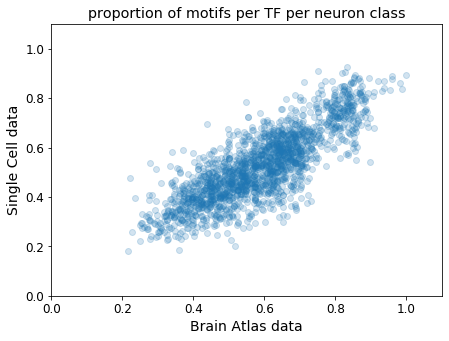

(0.010145862102303569, 0.663445517318729)
SpearmanrResult(correlation=0.01202327139835179, pvalue=0.6060713202403425)


(0, 1.1)

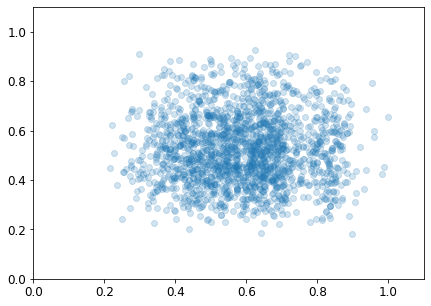

In [12]:
#sns.set_style("whitegrid")
rcParams['figure.figsize'] = 7, 5
x=m['obs_motif_x']/m['marker_count_x'].values
y=m['obs_motif_y']/m['marker_count_y'].values
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x,y))
plt.scatter(x,y,alpha=.2)
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.title("proportion of motifs per TF per neuron class")
plt.ylabel('Single Cell data')
plt.xlabel('Brain Atlas data')
plt.savefig('../../output/figure_parts/Fig11_motif_prop_ba_sc_scatter.pdf')
plt.show()
random.shuffle(x)
random.shuffle(y)
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x,y))
plt.scatter(x,y,alpha=.2)
plt.xlim(0,1.1)
plt.ylim(0,1.1)

(0.1500684318935246, 5.148563561363154e-10)
SpearmanrResult(correlation=0.12653506517811805, pvalue=1.6831818769374066e-07)


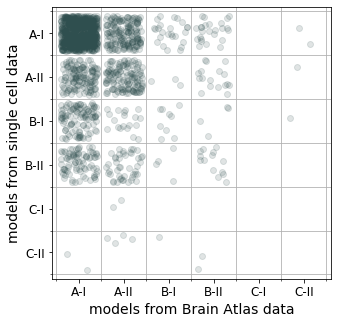

(-0.025996911845566045, 0.284330659012042)
SpearmanrResult(correlation=-0.03889899972723812, pvalue=0.10908283910914726)


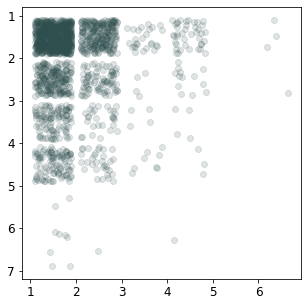

In [13]:
m=ba_df.merge(sc_df,on=['motif_ID','neuron_class', 'TF'])
model_dic={'A-I':1,'A-II':2,'B-I':3,'B-II':4,'C-I':5,'C-II':6 }
x=[model_dic[i] for i in m['model_x'].values]
y=[model_dic[i] for i in m['model_y'].values]

#try randomly distributing each category about the x and y values so that number of markers on plot shows number of correlated 
#make list of random numbers between .1 and .9 the length of x.
random.seed(1)
r=[random.randint(10, 90)/100.0 for i in range(len(x))]
random.seed(2)
r2=[random.randint(10, 90)/100.0 for i in range(len(y))]

x=[float(x[i])+r[i] for i in range(len(x))]
y=[float(y[i])+r2[i] for i in range(len(y))]
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x,y))

#scatter plot

rcParams['figure.figsize'] = 5, 5

ax=plt.scatter(x,y,alpha=.15,color=['darkslategrey'])
plt.xlim(.9,7.1)
plt.ylim(.9,7.1)
xlabels=['A-I', 'A-II','B-I','B-II','C-I','C-II']
ind = np.arange(1.5,len(xlabels)+1,1)# the x locations for the groups
plt.xticks(ind, xlabels, rotation=0)
plt.yticks(ind, xlabels, rotation=0)

plt.xlabel('models from Brain Atlas data')
plt.ylabel('models from single cell data')
minor_locator = AutoMinorLocator(2)
plt.gca().xaxis.set_minor_locator(minor_locator)
plt.gca().yaxis.set_minor_locator(minor_locator)
plt.gca().grid(b=True, which='minor', axis='both')
plt.gca().invert_yaxis()
plt.savefig('../../output/figure_parts/Fig11_ba_sc_model_compare_scatter.pdf')
plt.show()


random.shuffle(x)
random.shuffle(y)
plt.gca().invert_yaxis()

ax=plt.scatter(x,y,alpha=.15,color=['darkslategrey'])
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x,y))


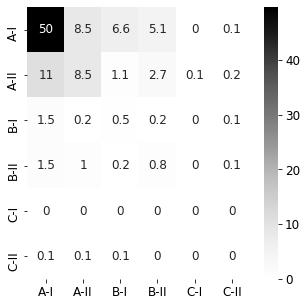

In [14]:
#make heatmap showing percentage of each category.
#importing seabron messing with pyplot settings in charts above. must restart kernal to get rid of
import seaborn as sns
m=ba_df.merge(sc_df,on=['motif_ID','neuron_class', 'TF'])
xlabels=['A-I', 'A-II','B-I','B-II','C-I','C-II']
d=pd.DataFrame()

for x in xlabels:
    plist=[]
    for y in xlabels: 
        l=len(m.loc[(m['model_x']==x) & (m['model_y']==y)].values)
        p=float('%.1f'%(float(l)/len(m)*100))
        #print(x,y,p)
        plist.append(p)
    #add plist as row in dataframe (col names are xlabels)
    dictionary = dict(zip(xlabels, plist))
    d=d.append(dictionary,ignore_index=True)
d.index=xlabels 
ax=sns.heatmap(d, annot=True,cmap="Greys",xticklabels=True, yticklabels=True)
#sns.heatmap(d,cmap="Greys")

#b, t = plt.ylim() # discover the values for bottom and top
#b += 0.5 # Add 0.5 to the bottom
#t -= 0.5 # Subtract 0.5 from the top
#plt.ylim(b, t) # update the ylim(bottom, top) values
#plt.show() # ta-da!

figure = ax.get_figure()    

figure.savefig('../../output/figure_parts/Fig11_ba_sc_model_compare_percent_heatmap.pdf')

In [15]:
#get the sum of the diagonal (equal to the percent of data that agrees 1:1)
sum(pd.Series(np.diag(d), index=[d.index, d.columns]))

59.5

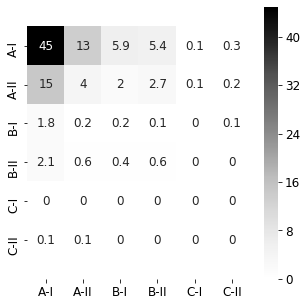

49.7


In [16]:
#check what proportion of data is in each category from randomly permuted models in each data set.
m=ba_df.merge(sc_df,on=['motif_ID','neuron_class', 'TF'])
mp=m

mp['model_x']=np.random.permutation(mp['model_x'])
mp['model_y']=np.random.permutation(mp['model_y'])

xlabels=['A-I', 'A-II','B-I','B-II','C-I','C-II']
d=pd.DataFrame()

for x in xlabels:
    plist=[]
    for y in xlabels: 
        l=len(mp.loc[(mp['model_x']==x) & (mp['model_y']==y)].values)
        p=float('%.1f'%(float(l)/len(m)*100))
        #print(x,y,p)
        plist.append(p)
    #add plist as row in dataframe (col names are xlabels)
    dictionary = dict(zip(xlabels, plist))
    d=d.append(dictionary,ignore_index=True)
d.index=xlabels 
sns.heatmap(d, annot=True,cmap="Greys",xticklabels=True, yticklabels=True)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!
print(sum(pd.Series(np.diag(d), index=[d.index, d.columns])))
figure = ax.get_figure()    


#figure.savefig('../../output/Fig11_ba_sc_model_compare_percent_heatmap.pdf')

(0.017411015987766478, 0.47338755925377324)
(0.017411015987766478, 0.47338755925377324)
(0.027030710344582574, 0.2656087564095496)
SpearmanrResult(correlation=0.021197654878871725, pvalue=0.38269454707715955)
[1.5 2.5 3.5]


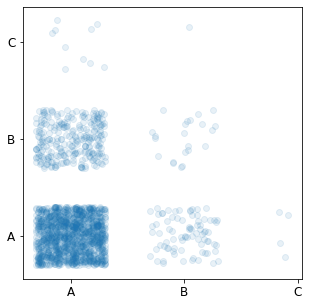

In [17]:
model_dic={'A-I':1,'A-II':1,'B-I':2,'B-II':2,'C-I':3,'C-II':3 }
x=[model_dic[i] for i in m['model_x'].values]
y=[model_dic[i] for i in m['model_y'].values]
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.pearsonr(x, y))

random.seed(1)
r=[random.randint(20, 80)/100.0 for i in range(len(x))]
random.seed(2)
r2=[random.randint(20, 80)/100.0 for i in range(len(y))]

x=[float(x[i])+r[i] for i in range(len(x))]
y=[float(y[i])+r2[i] for i in range(len(y))]
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x,y))
plt.scatter(x,y,alpha=.1)

xlabels=['A', 'B','C']

ind = np.arange(1.5,len(xlabels)+1,1)# the x locations for the groups
print(ind)
width = 0.35       # the width of the bars: can also be len(x) sequence
plt.xticks(ind, xlabels, rotation=0)
plt.yticks(ind, xlabels, rotation=0)
plt.show()

In [13]:
x=list(m["hg_pval*_x"].values)
y=list(m["hg_pval*_y"].values)
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x,y))

(0.15657521868588237, 7.044666259525331e-11)
SpearmanrResult(correlation=0.3044671654996487, pvalue=4.0979255391197434e-38)


In [14]:
x=list(m["hg_pval*_x"].values)
y=list(m["hg_pval*_y"].values)
x=[-1*math.log10(i) for i in x]
y=[-1*math.log10(i) for i in y]
print(scipy.stats.pearsonr(x, y))
print(scipy.stats.spearmanr(x,y))


(0.32426011446585407, 2.8073307869336344e-43)
SpearmanrResult(correlation=0.3044671654996487, pvalue=4.0979255391197434e-38)
